In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 8.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import shap
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

df_desharnais = pd.read_csv('/content/02.desharnais.csv', header=0)
features = ['TeamExp', 'ManagerExp', 'Length', 'Transactions', 'Entities',
            'PointsNonAdjust', 'Adjustment', 'PointsAjust']
X = df_desharnais[features]
y = df_desharnais['Effort']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train base models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
lasso_model = Lasso(alpha=0.1, random_state=42)

rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)

# Compute SHAP values and select top features
rf_explainer = shap.Explainer(rf_model)
gb_explainer = shap.Explainer(gb_model)
lasso_explainer = shap.Explainer(lasso_model.predict, X_train)

rf_shap_values = rf_explainer(X_train)
gb_shap_values = gb_explainer(X_train)
lasso_shap_values = lasso_explainer(X_train)

aggregate_shap_values = np.abs(rf_shap_values.values) + np.abs(gb_shap_values.values) + np.abs(lasso_shap_values.values)
average_shap_values = np.mean(aggregate_shap_values, axis=0)
num_selected_features = 5
selected_features_indices = np.argsort(average_shap_values)[-num_selected_features:]

X_train_selected = X_train.iloc[:, selected_features_indices]
X_test_selected = X_test.iloc[:, selected_features_indices]

# Train meta-learner
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train_selected, y_train)
gb_model.fit(X_train_selected, y_train)

# Train meta-learner
rf_train_pred = rf_model.predict(X_train_selected)
gb_train_pred = gb_model.predict(X_train_selected)

meta_train_features = np.column_stack((rf_train_pred, gb_train_pred))

meta_learner = LinearRegression()
meta_learner.fit(meta_train_features, y_train)

# Evaluate meta-learner on test set
y_pred = meta_learner.predict(np.column_stack((rf_model.predict(X_test_selected), gb_model.predict(X_test_selected))))
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.315e+08, tolerance: 1.340e+05
  model = cd_fast.enet_coordinate_descent(


Mean Squared Error: 6628649.37
R-squared: 0.48


In [ ]:
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error (MAE): 2120.241546191577
Mean Squared Error (MSE): 6628649.367754691
Root Mean Squared Error (RMSE): 2574.61635350875


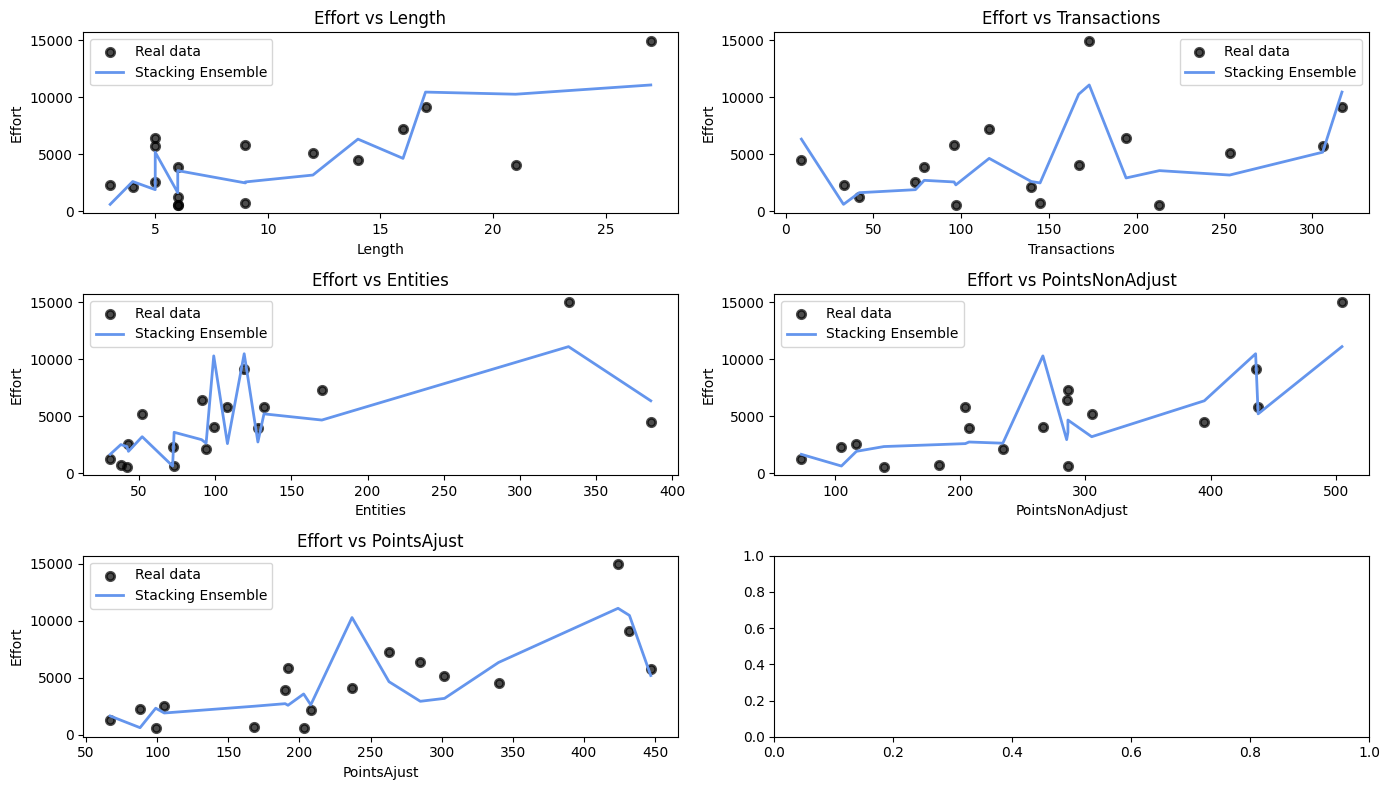

In [ ]:
  import matplotlib.pyplot as plt
import numpy as np

features = [ 'Length', 'Transactions', 'Entities', 'PointsNonAdjust', 'PointsAjust']
num_features = len(features)

# Create a figure with subplots for each feature
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14,8))
axs = axs.flatten()

# Stacking Ensemble
for i, feature in enumerate(features):
    xs, ys = zip(*sorted(zip(X_test[feature], y_test)))
    model_xs, model_ys = zip(*sorted(zip(X_test[feature], y_pred)))

    axs[i].scatter(xs, ys, label='Real data', lw=2, alpha=0.7, c='k')
    axs[i].plot(model_xs, model_ys, lw=2, label='Stacking Ensemble', c='cornflowerblue')

    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Effort')
    axs[i].set_title(f'Effort vs {feature}')
    axs[i].legend()

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

# Load the dataset
df_desharnais = pd.read_csv('/content/02.desharnais.csv', header=0)
features = ['Length', 'Transactions', 'Entities', 'PointsNonAdjust', 'PointsAjust']
X = df_desharnais[features]
y = df_desharnais['Effort']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost
print("XGBoost Evaluation:")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred_xgb))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred_xgb))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("R-squared (R2):", r2_score(y_test, y_pred_xgb))
print()

# LightGBM
lgb_model = lgb.LGBMRegressor(objective='regression', n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate LightGBM
print("LightGBM Evaluation:")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred_lgb))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred_lgb))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred_lgb)))
print("R-squared (R2):", r2_score(y_test, y_pred_lgb))
print()

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest
print("Random Forest Evaluation:")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred_rf))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred_rf))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R-squared (R2):", r2_score(y_test, y_pred_rf))

XGBoost Evaluation:
Mean Absolute Error (MAE): 2081.4216380399816
Mean Squared Error (MSE): 9025248.07742567
Root Mean Squared Error (RMSE): 3004.20506580787
R-squared (R2): 0.2926230532016154

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 5
[LightGBM] [Info] Start training from score 5181.921875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

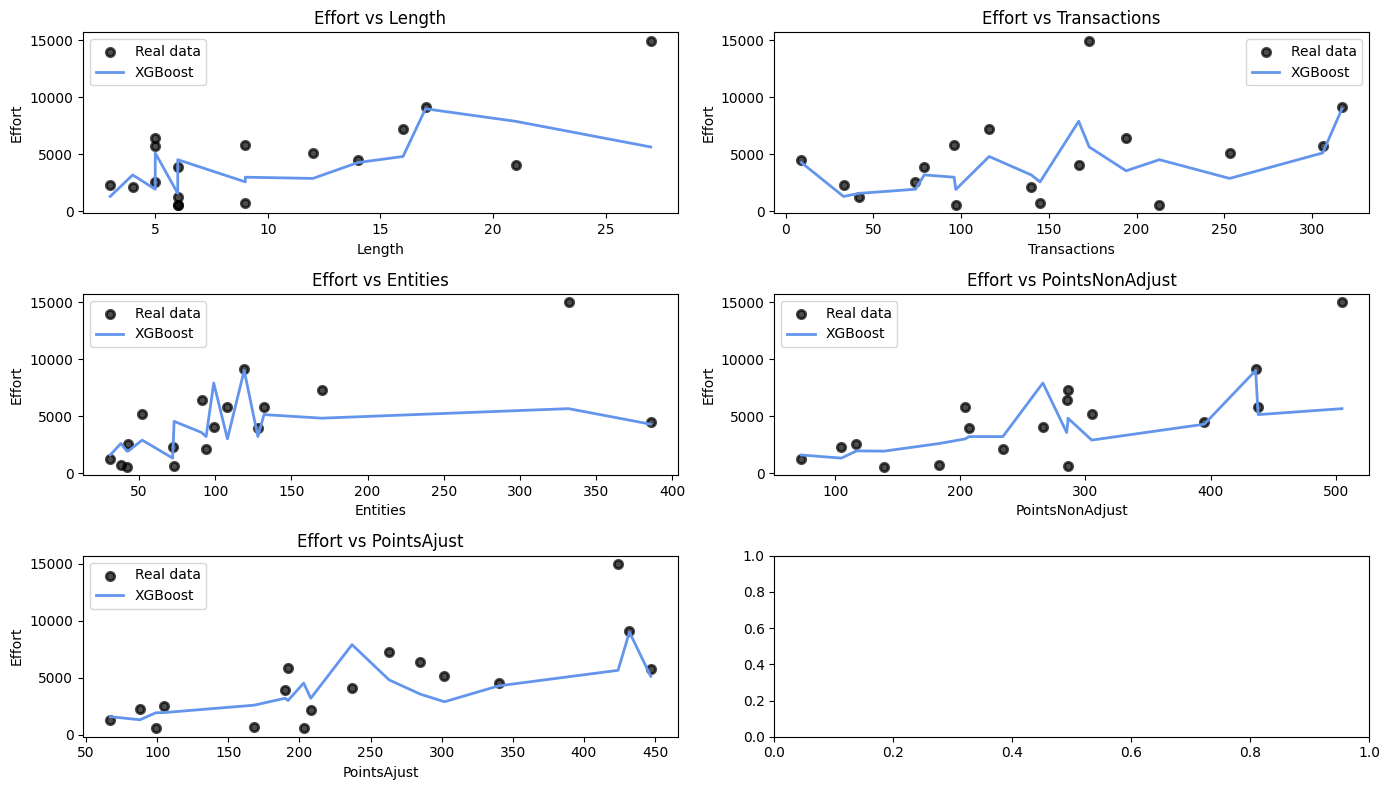

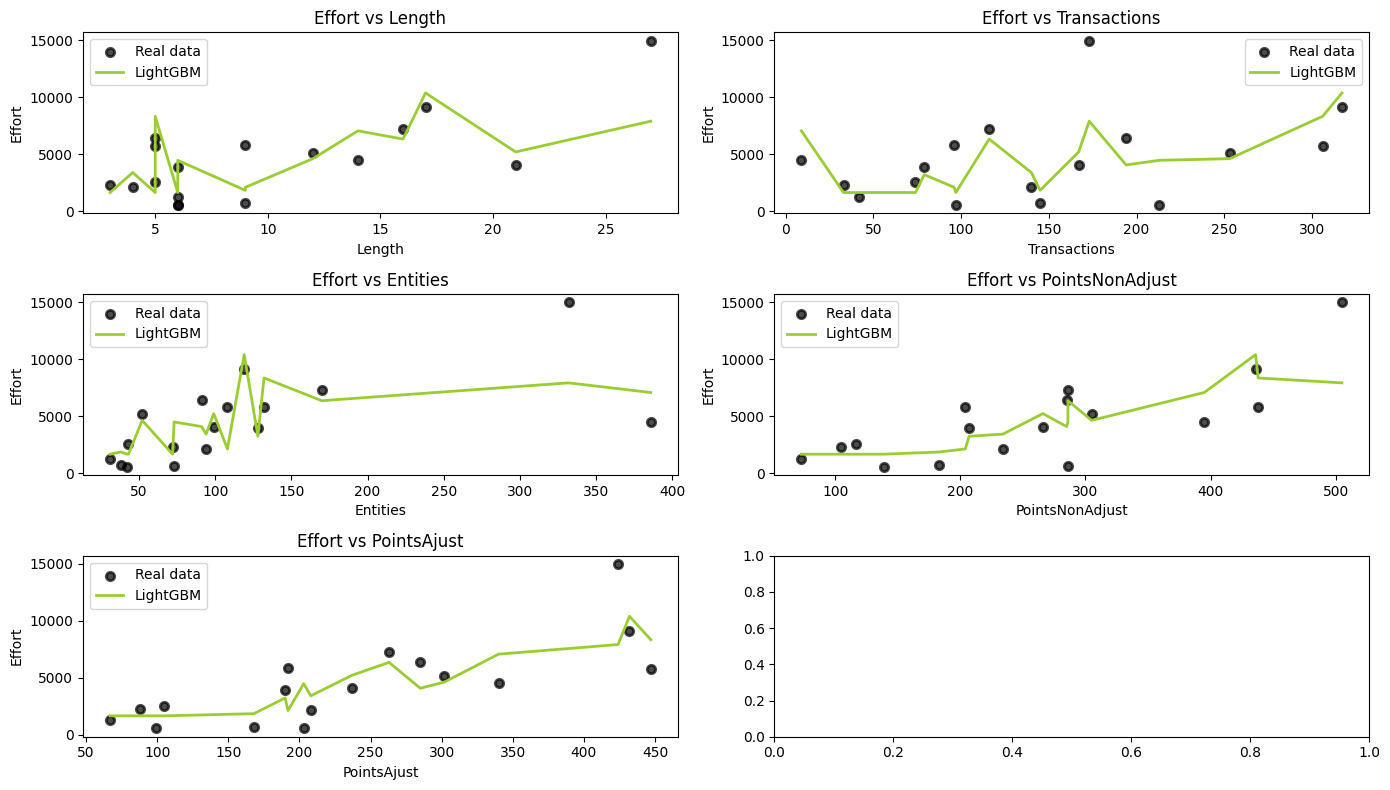

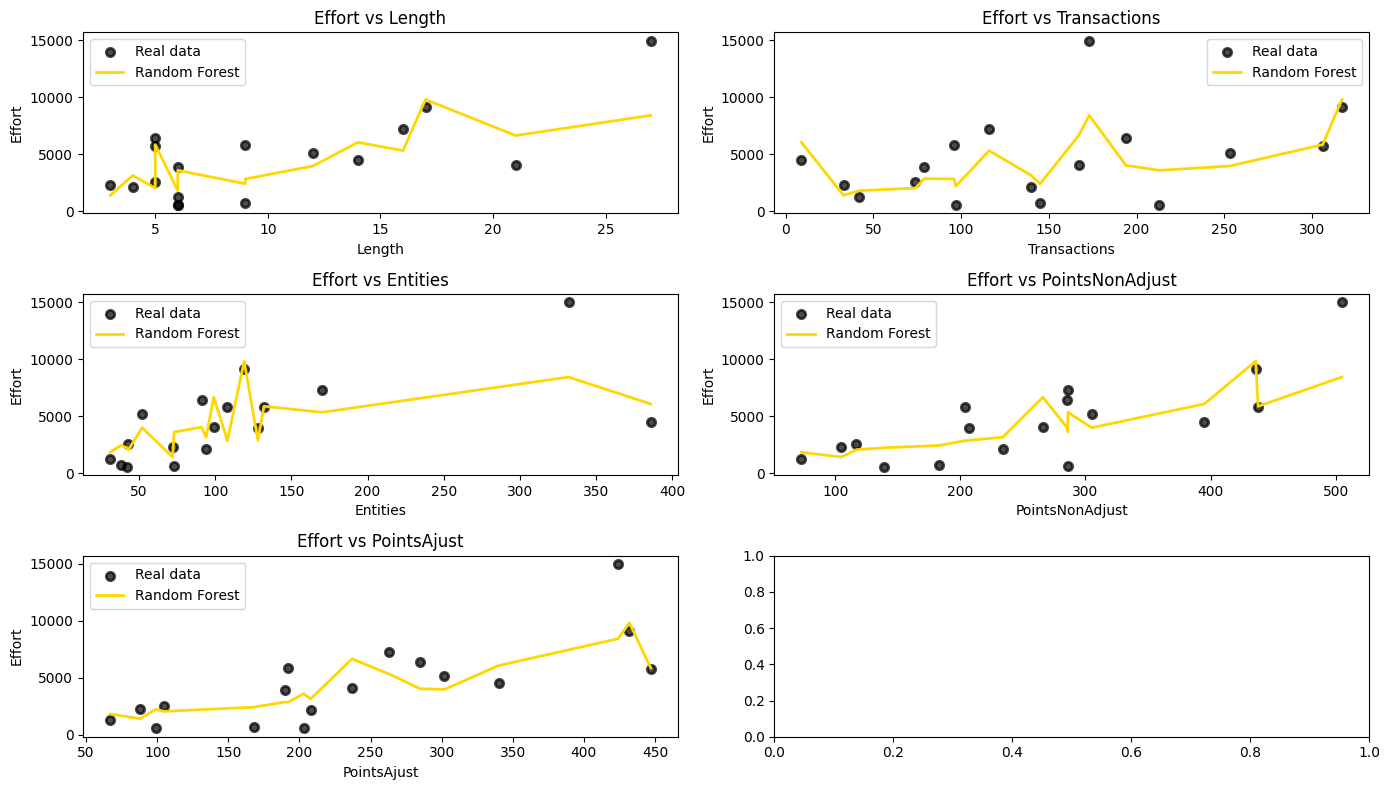

In [ ]:
import matplotlib.pyplot as plt

features = [ 'Length', 'Transactions', 'Entities', 'PointsNonAdjust', 'PointsAjust']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14,8))
axs = axs.flatten()


for i, feature in enumerate(features):
    xs, ys = zip(*sorted(zip(X_test[feature], y_test)))
    model_xs, model_ys = zip(*sorted(zip(X_test[feature], y_pred_xgb)))

    axs[i].scatter(xs, ys, label='Real data', lw=2, alpha=0.7, c='k')
    axs[i].plot(model_xs, model_ys, lw=2, label='XGBoost', c='cornflowerblue')

    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Effort')
    axs[i].set_title(f'Effort vs {feature}')
    axs[i].legend()

# Adjust spacing between subplots
plt.tight_layout()
plt.show()# XGBoost

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14,8))
axs = axs.flatten()


for i, feature in enumerate(features):
    xs, ys = zip(*sorted(zip(X_test[feature], y_test)))
    model_xs, model_ys = zip(*sorted(zip(X_test[feature], y_pred_lgb)))

    axs[i].scatter(xs, ys, label='Real data', lw=2, alpha=0.7, c='k')
    axs[i].plot(model_xs, model_ys, lw=2, label='LightGBM', c='yellowgreen')

    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Effort')
    axs[i].set_title(f'Effort vs {feature}')
    axs[i].legend()

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14,8))
axs = axs.flatten()

# Stacking Ensemble
for i, feature in enumerate(features):
    xs, ys = zip(*sorted(zip(X_test[feature], y_test)))
    model_xs, model_ys = zip(*sorted(zip(X_test[feature], y_pred_rf)))

    axs[i].scatter(xs, ys, label='Real data', lw=2, alpha=0.7, c='k')
    axs[i].plot(model_xs, model_ys, lw=2, label='Random Forest', c='gold')

    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Effort')
    axs[i].set_title(f'Effort vs {feature}')
    axs[i].legend()

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [ ]:
for feature in features:
    plt.figure(figsize=(18, 6))
    xs, ys = zip(*sorted(zip(X_test[feature], y_test)))
    model_xs, model_ys = zip(*sorted(zip(X_test[feature], y_pred_xgb)))

    plt.scatter(xs, ys, label='Real data', lw=2, alpha=0.7, c='k')
    plt.plot(model_xs, model_ys, lw=2, label='XGBoost', c='cornflowerblue')

    plt.xlabel(feature)
    plt.ylabel('Effort')
    plt.title(f'XGBoost: Effort vs {feature}')
    plt.legend()
    plt.show()

# LightGBM
for feature in features:
    plt.figure(figsize=(18, 6))
    xs, ys = zip(*sorted(zip(X_test[feature], y_test)))
    model_xs, model_ys = zip(*sorted(zip(X_test[feature], y_pred_lgb)))

    plt.scatter(xs, ys, label='Real data', lw=2, alpha=0.7, c='k')
    plt.plot(model_xs, model_ys, lw=2, label='LightGBM', c='yellowgreen')

    plt.xlabel(feature)
    plt.ylabel('Effort')
    plt.title(f'LightGBM: Effort vs {feature}')
    plt.legend()
    plt.show()

# Random Forest
for feature in features:
    plt.figure(figsize=(18, 6))
    xs, ys = zip(*sorted(zip(X_test[feature], y_test)))
    model_xs, model_ys = zip(*sorted(zip(X_test[feature], y_pred_rf)))

    plt.scatter(xs, ys, label='Real data', lw=2, alpha=0.7, c='k')
    plt.plot(model_xs, model_ys, lw=2, label='Random Forest', c='gold')

    plt.xlabel(feature)
    plt.ylabel('Effort')
    plt.title(f'Random Forest: Effort vs {feature}')
    plt.legend()
    plt.show()